In [1]:
import pandas as pd
import numpy as np
import bilby
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import copy

from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
from create_post_dict import create_post_dict, extract_relevant_info

In [2]:
def call_data_GWOSC(logger, args, calibration, samples, detectors, start_time, end_time, psd_start_time, psd_end_time, duration, sampling_frequency, roll_off, minimum_frequency, maximum_frequency, psds_array=None, plot=False):
    
    ifo_list = bilby.gw.detector.InterferometerList([])
    
    # define interferometer objects
    for det in detectors:   
        logger.info("Downloading analysis data for ifo {}".format(det))
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        
        channel_type = args['channel_dict'][det]
        channel = f"{det}:{channel_type}"
        
        kwargs = dict(
            start=start_time,
            end=end_time,
            verbose=False,
            allow_tape=True,
        )

        type_kwargs = dict(
            dtype="float64",
            subok=True,
            copy=False,
        )
        data = gwpy.timeseries.TimeSeries.get(channel, **kwargs).astype(
                **type_kwargs)
        
        # Resampling timeseries to sampling_frequency using lal.
        lal_timeseries = data.to_lal()
        lal.ResampleREAL8TimeSeries(
            lal_timeseries, float(1/sampling_frequency)
        )
        data = TimeSeries(
            lal_timeseries.data.data,
            epoch=lal_timeseries.epoch,
            dt=lal_timeseries.deltaT
        )
    
        # define some attributes in ifo
        ifo.strain_data.roll_off = roll_off
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        
        # set data as the strain data
        ifo.strain_data.set_from_gwpy_timeseries(data)
        
        # compute the psd
        if det in psds_array.keys():
            print("Using pre-computed psd from results file")
            ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=psds_array[det][: ,0], psd_array=psds_array[det][:, 1]
            )
        else:
            print('Error: PSD is missing!')
            exit()

        ifo_list.append(ifo)

    return ifo_list

In [44]:
events_name = 'GW200302' 
file_path = '/home/shunyin.cheung/GWOSC_posteriors/IGWN-GWTC3p0-v1-GW200302_015811_PEDataRelease_mixed_cosmo.h5'
waveform = "C01:IMRPhenomXPHM"
data_file = None

amplitude = 50
print('amplitude = ',amplitude)

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)
args = extract_relevant_info(meta_dict, config_dict)

priors2 = copy.copy(priors)

logger = bilby.core.utils.logger

sampling_frequency = args['sampling_frequency']
maximum_frequency = args['maximum_frequency']
minimum_frequency = args['minimum_frequency']
reference_frequency = args['reference_frequency']
roll_off = args['tukey_roll_off']
duration = args['duration']
post_trigger_duration = args['post_trigger_duration']
trigger_time = args['trigger_time']
detectors = args['detectors']

detectors = args['detectors']
if 'V1' in detectors:
    detectors.remove('V1')

end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

psd_duration = 32*duration # deprecated
psd_start_time = start_time - psd_duration # deprecated
psd_end_time = start_time # deprecated


amplitude =  50
Jitter time setting cannot be found. Use default setting.
channel_dict {'H1': 'DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01', 'V1': 'Hrec_hoft_16384Hz'}


In [31]:
ifo_list = call_data_GWOSC(logger, args, 
                            calibration, samples, detectors,
                            start_time, end_time, 
                            psd_start_time, psd_end_time, 
                            duration, sampling_frequency, 
                            roll_off, minimum_frequency, maximum_frequency,
                            psds_array=psds)

20:43 bilby INFO    : Downloading analysis data for ifo H1


Using pre-computed psd from results file


In [45]:
waveform_name = args['waveform_approximant']

amplitude = 1
print('amplitude = ',amplitude)

# test if bilby oscillatory waveform = gwmemory oscillatory waveform.
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

# define oscillatory + memory model using gwmemory.
waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

target_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator_full,
    time_marginalization = True,
    distance_marginalization = True,
    distance_marginalization_lookup_table = "'TD.npz'.npz",
    jitter_time=True,
    priors = priors,
    reference_frame = args['reference_frame'],
    time_reference = args['time_reference'],
)
print(args['reference_frame'])
print(args['time_reference'])

20:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


amplitude =  1


20:46 bilby INFO    : Loaded distance marginalisation lookup table from 'TD.npz'.npz.


H1V1
geocent


In [46]:
mean_parameters = dict()
for key in samples:
    value = np.mean(samples[key])
    mean_parameters[key] = value
    print(key, value)
posterior = mean_parameters

chirp_mass 29.582700386999147
mass_ratio 0.5246535569264629
a_1 0.394566253588848
a_2 0.4711618927308135
tilt_1 1.628933016163738
tilt_2 1.5308133116917346
phi_12 3.1389618907235963
phi_jl 3.1112753080669453
theta_jn 1.4214795532311664
psi 1.5514010930343984
phase 2.5082453117667485
azimuth 3.7904186471567
zenith 1.5868824010383662
recalib_H1_amplitude_0 -0.012419718487650219
recalib_H1_amplitude_1 -0.010161657884543793
recalib_H1_amplitude_2 0.008977303790953264
recalib_H1_amplitude_3 0.022259185978268713
recalib_H1_amplitude_4 0.0032302987709198223
recalib_H1_amplitude_5 -0.005637701132820977
recalib_H1_amplitude_6 -0.0026985901843639567
recalib_H1_amplitude_7 0.002622690762101328
recalib_H1_amplitude_8 0.006076930200948951
recalib_H1_amplitude_9 0.008495829676674262
recalib_H1_phase_0 -0.014477810072888477
recalib_H1_phase_1 0.011781548317636545
recalib_H1_phase_2 0.017467169540166458
recalib_H1_phase_3 -0.001305634850361018
recalib_H1_phase_4 -0.016358962002507135
recalib_H1_phase_

In [49]:
frequency_domain_strain = waveform_generator_full.frequency_domain_strain(posterior)
time_domain_strain_osc = waveform_generator_osc.time_domain_strain(posterior)
time_domain_strain_full = waveform_generator_full.time_domain_strain(posterior)
time_domain_strain_mem = waveform_generator_mem.time_domain_strain(posterior)
time_array = waveform_generator_full.time_array
target_likelihood.parameters.update(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[0])
opt_snr_H = snr_array_H1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
print('full waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H))
print('network complex matched_filter SNR', cmf_snr_H)

length of waveform array,  8193
length of waveform array,  8193
full waveform
network opt SNR:  1.410554203730321
network complex matched_filter SNR (-4.589952090309368-7.798692101763571j)


In [24]:
frequency_domain_strain_mem = waveform_generator_mem.frequency_domain_strain(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain_mem, ifo_list[0])
opt_snr_H = snr_array_H1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr

print('memory-only waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H))
print('network complex matched_filter SNR', cmf_snr_H)

memory-only waveform
network opt SNR:  0.007452634682179739
network complex matched_filter SNR (-2.016527466132971+3.236346726010191j)


/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


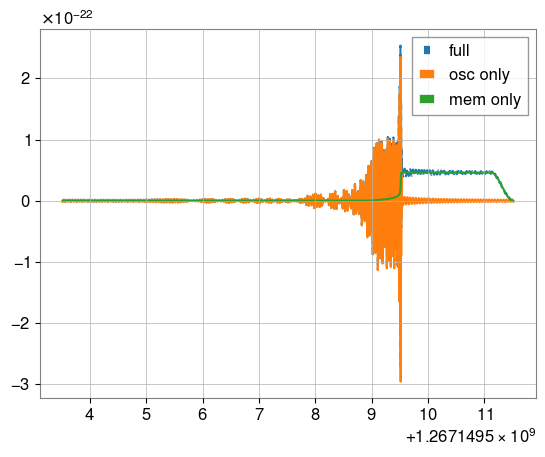

In [25]:
plt.figure()
plt.plot(time_array, np.roll(time_domain_strain_full['plus']-1j*time_domain_strain_full['cross'], -4096), linestyle='dashed', label='full')
plt.plot(time_array, np.roll(time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], -4096), label='osc only')
plt.plot(time_array, np.roll(time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], -4096), label='mem only')
plt.legend()
plt.savefig(f'tests/td_waveform_{amplitude}_{events_name}.png')
plt.show()

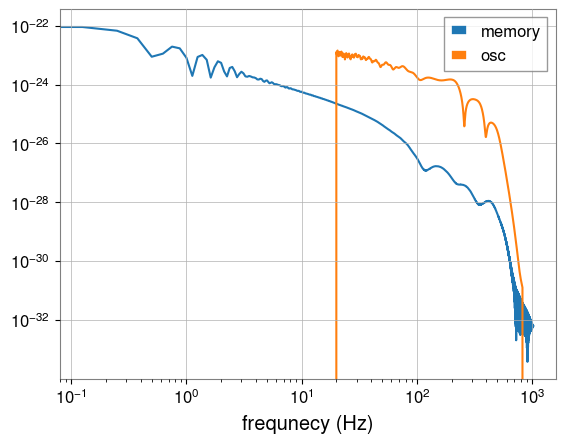

In [16]:
frequency_array = waveform_generator_mem.frequency_array
fd_strain_osc = waveform_generator_osc.frequency_domain_strain(posterior)

plt.figure()
plt.loglog(frequency_array, np.abs(frequency_domain_strain_mem['plus']+frequency_domain_strain_mem['cross']), label='memory')
plt.loglog(frequency_array, np.abs(fd_strain_osc['plus']+fd_strain_osc['cross']), label='osc')
plt.xlabel('frequnecy (Hz)')
plt.legend()
plt.show()